In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm

sns.set()

In [3]:
def parse_scb_prel():
    
    def monthname2number(m):
        if m == 'januari' : return 1
        if m == 'februari' : return 2
        if m == 'mars' : return 3
        if m == 'april' : return 4
        if m == 'maj' : return 5
        if m == 'juni' : return 6
        if m == 'juli' : return 7
        if m == 'augusti' : return 8
        if m == 'september' : return 9
        if m == 'oktober' : return 10
        if m == 'november' : return 11
        if m == 'december' : return 12

    df = pd.read_csv('scb-dead_per_day.csv',sep=';',usecols=[1,2,3,4,5,6,7,10,11],thousands=' ')
    
    df['month'] = df['Månad'].apply(monthname2number)
    df[['Månad','month']] = df[['Månad','month']].replace(np.nan,0)
    df['month'] = df['month'].astype(int)
    
    unknown_death_day = df.iloc[-1,:7]
    
    df.drop(366,inplace=True)
    
    df = df.loc[df['2020'] != 0]
    df = df.drop('Månad',axis=1)
    
    known_death_day = df.iloc[:,:7].sum()
    
    year_fraction = len(df) / 366
    
    unknown_death_day[['2015','2016','2017','2018','2019','2015-2019']] = unknown_death_day[
    ['2015','2016','2017','2018','2019','2015-2019']] * year_fraction
    
    dead_pct_per_day = df[['2015','2016','2017','2018','2019','2020','2015-2019']] / known_death_day
    
    all_deaths = df[['2015','2016','2017','2018','2019','2020','2015-2019']] + unknown_death_day * dead_pct_per_day
    
    index = pd.date_range('2020-01-01',periods=len(all_deaths))
    all_deaths.index = index
    
    return all_deaths
    

In [11]:
scb = parse_scb_prel()
last_data_day = last_day = '2020-08-07'

scb = pd.read_csv('scb-dead_per_day.csv',sep=';',usecols=[1,2,3,4,5,6,7])
scb.index = pd.date_range('2020-01-01','2020-12-31')
scb.drop(pd.Timestamp('2020-02-29'),inplace=True,axis=0)
last_day = scb.loc[scb['2020'] == 0]
last_day = last_day.iloc[0]
last_day = last_day.name.date()
last_data_day = last_day - pd.DateOffset(days=1)

last_day = (last_day - pd.DateOffset(days=7)).date() # skip last 6 days; last day is one day after before call


In [7]:
daily_min = scb.loc[:,'2015' : '2019'].min(axis=1)
daily_max = scb.loc[:,'2015' : '2019'].max(axis=1)
daily_mean = scb.loc[:,'2015' : '2019'].mean(axis=1)
cum_diff = scb.loc[:last_day,'2020'].sum() - scb.loc[:last_day,'2015-2019'].sum()
cum_diff

3291.1530054644827

In [8]:
excess = scb.loc[:last_day,'2020'] - scb.loc[:last_day,'2015-2019']
excess

2020-01-01    -36.957043
2020-01-02     11.266075
2020-01-03    -33.882216
2020-01-04     -5.193076
2020-01-05    -14.421022
                 ...    
2020-08-03    -45.425763
2020-08-04    -85.415839
2020-08-05   -154.167839
2020-08-06   -186.004589
2020-08-07   -221.893741
Freq: D, Length: 220, dtype: float64

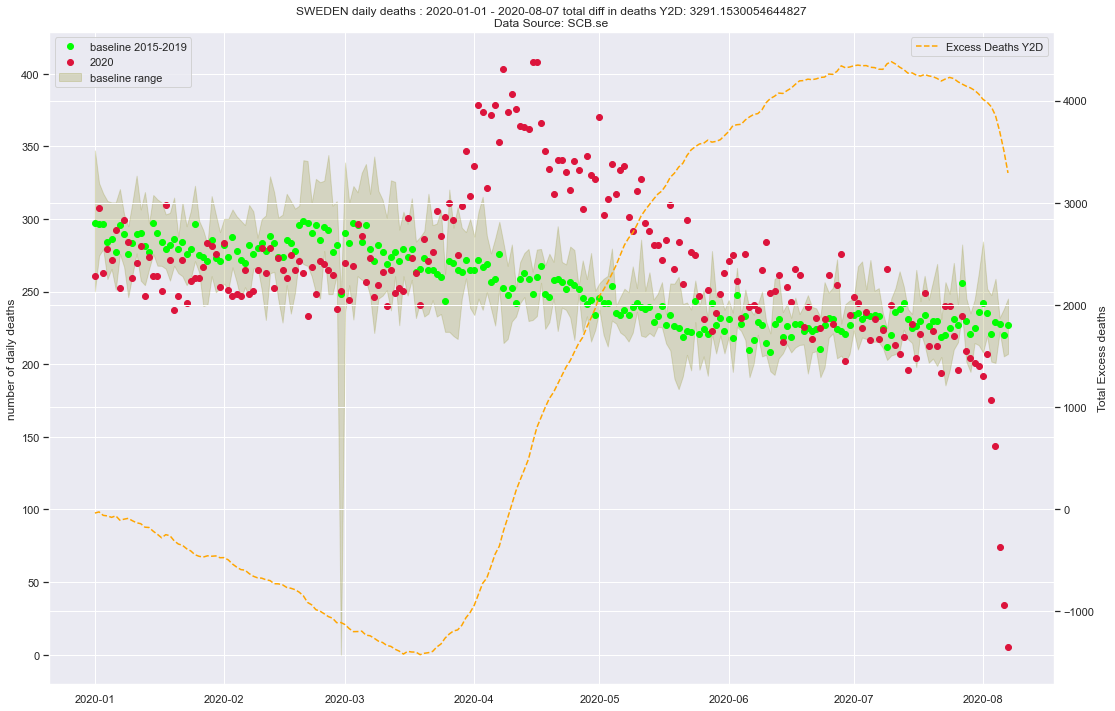

In [9]:
plt.figure(figsize=(18,12))
ax = plt.gca()
ax2 = plt.twinx()

ax.plot(scb['2015-2019'],'o',color='lime',label='baseline 2015-2019')
ax.fill_between(scb.index,y1=daily_min,y2=daily_max,color='olive',alpha=0.2,label='baseline range')
ax.plot(scb.loc[:last_day,'2020'],'o',color='crimson',label='2020')
ax.set_title('SWEDEN daily deaths : 2020-01-01 - {} total diff in deaths Y2D: {}\nData Source: SCB.se'.format(last_day,cum_diff))
ax.set_ylabel('number of daily deaths')
ax.legend(loc='upper left')
ax2.plot(excess.cumsum(),ls='dashed',color='orange',label='Excess Deaths Y2D')
ax2.set_ylabel('Total Excess deaths')
ax2.legend(loc='upper right')

plt.savefig('SCB_compare_with_interval.jpg',format='jpg')

In [12]:
scb_weekly = scb.resample('W-TUE').sum()
scb_weekly.loc[:last_data_day]

,2015,2016,2017,2018,2019,2020,2015-2019
2020-01-07,1957.085974,1886.467044,2245.476963,2052.158160,2024.518096,1927.011140,2034.014369
2020-01-14,1974.262257,1945.738490,2160.452060,1993.613108,1856.580972,1915.724067,1986.973313
2020-01-21,1957.085974,2012.163386,2138.939735,1997.721532,1887.489645,1837.740656,1999.244893
2020-01-28,1949.003017,2020.338758,1968.889928,1980.260727,1861.732417,1840.818948,1956.294363
2020-02-04,1986.386693,1973.330370,1959.670360,1904.254870,1927.670920,1840.818948,1951.181205
2020-02-11,1937.888951,1954.935783,1877.718646,2036.751568,1902.943982,1818.244803,1941.977520
2020-02-18,2071.257742,1822.085991,2052.890435,2078.862921,1807.127095,1869.549679,1966.520680
2020-02-25,2171.284335,1915.080846,2121.524996,2173.356690,1906.034849,1821.323096,2057.534898
2020-03-03,1761.074265,1845.590185,1793.718140,1927.878312,1539.251927,1796.696755,1971.633838
2020-03-10,2049.029610,1938.585040,1918.694503,2281.202840,1741.188592,1878.784557,1984.928050


In [13]:
weekly_min = scb_weekly.loc[:,'2015' : '2019'].min(axis=1)
weekly_max = scb_weekly.loc[:,'2015' : '2019'].max(axis=1)
weekly_mean = scb_weekly.loc[:,'2015' : '2019'].mean(axis=1)
weekly_cum_diff = scb_weekly.loc[:last_data_day,'2020'].sum() - scb_weekly.loc[:last_data_day,'2015-2019'].sum()
weekly_cum_diff

3853.2191732501306

In [15]:
weekly_excess = scb_weekly.loc[:last_data_day,'2020'] - scb_weekly.loc[:last_data_day,'2015-2019']
weekly_excess

2020-01-07   -107.003229
2020-01-14    -71.249246
2020-01-21   -161.504237
2020-01-28   -115.475415
2020-02-04   -110.362257
2020-02-11   -123.732717
2020-02-18    -96.971001
2020-02-25   -236.211802
2020-03-03   -174.937083
2020-03-10   -106.143493
2020-03-17    -93.012177
2020-03-24     78.110430
2020-03-31    308.968508
2020-04-07    648.655309
2020-04-14    852.547186
2020-04-21    734.587561
2020-04-28    559.024376
2020-05-05    601.915986
2020-05-12    542.291422
2020-05-19    359.524759
2020-05-26    292.651661
2020-06-02    171.631073
2020-06-09    156.229213
2020-06-16    211.485981
2020-06-23    104.823827
2020-06-30    101.825249
2020-07-07    -21.136626
2020-07-14    -38.684259
2020-07-21    -52.033925
2020-07-28    -75.613372
2020-08-04   -286.982529
Freq: W-TUE, dtype: float64

In [16]:
last_week = scb_weekly.loc[:last_data_day].index[-1].date()
last_week

datetime.date(2020, 8, 4)

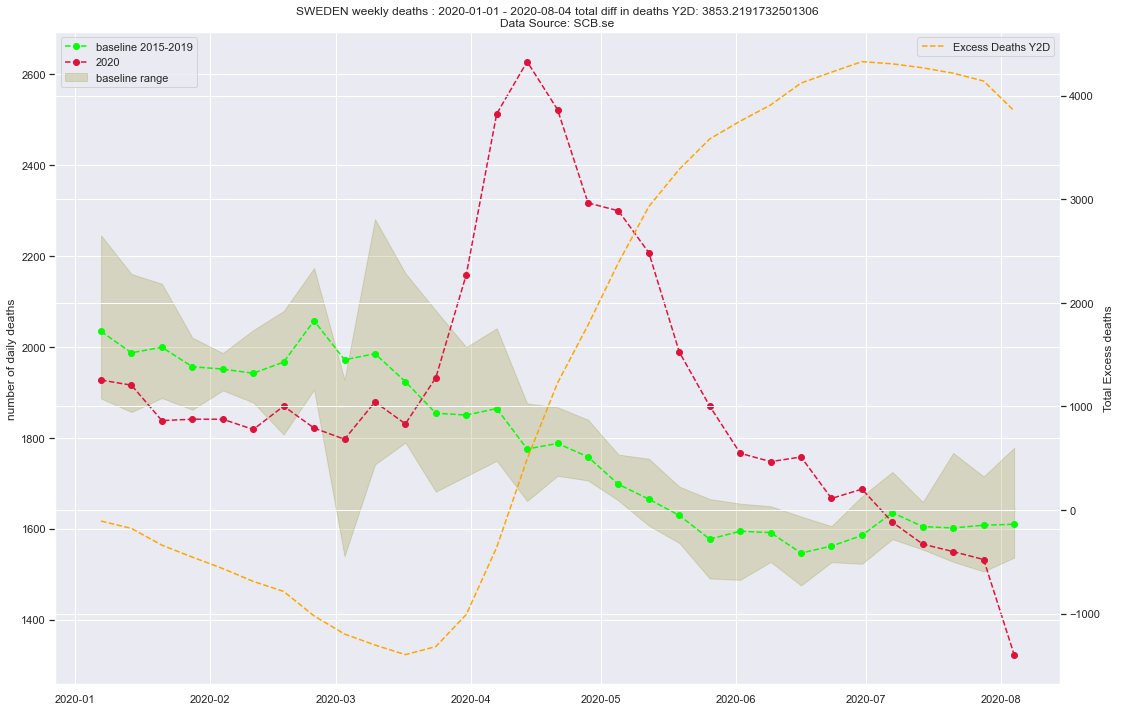

In [17]:
plt.figure(figsize=(18,12))
ax = plt.gca()
ax2 = plt.twinx()

ax.plot(scb_weekly['2015-2019'][:-1],'o--',color='lime',label='baseline 2015-2019')
ax.fill_between(scb_weekly.index[:-1],y1=weekly_min[:-1],y2=weekly_max[:-1],color='olive',alpha=0.2,label='baseline range')
ax.plot(scb_weekly.loc[:last_week,'2020'],'o--',color='crimson',label='2020')
ax.set_title('SWEDEN weekly deaths : 2020-01-01 - {} total diff in deaths Y2D: {}\nData Source: SCB.se'.format(last_week,
                                                                                                               weekly_cum_diff))
ax.set_ylabel('number of daily deaths')
ax.legend(loc='upper left')
ax2.plot(weekly_excess.cumsum(),ls='dashed',color='orange',label='Excess Deaths Y2D')
ax2.set_ylabel('Total Excess deaths')
ax2.legend(loc='upper right')

plt.savefig('SCB_compare_weekly_with_interval.jpg',format='jpg')